## Subclassing BaseNetwork: Variational Autoencoder
In this notebook we will subclass `BaseNetwork` to create a variational autoencoder. 

The code below is adapted from the example in the Keras documentation to work in the deep_lincs framework.

In [2]:
from tensorflow.keras.layers import Lambda, Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
import numpy as np
import pandas as pd
import altair as alt

In [3]:
from deep_lincs.models import BaseNetwork


class Vae(BaseNetwork):
    def __init__(self, dataset, **kwargs):
        super(Vae, self).__init__(dataset=dataset, target="self", **kwargs)
        self.in_size = dataset.data.shape[1]
        self.out_size = dataset.data.shape[1]

    def compile_model(self, intermediate_dim=512, latent_dim=2, activation="relu"):
        # VAE model = encoder + decoder
        # build encoder model
        inputs = Input(shape=(self.in_size,), name="encoder_input")
        x = Dense(intermediate_dim, activation=activation)(inputs)
        z_mean = Dense(latent_dim, name="z_mean")(x)
        z_log_var = Dense(latent_dim, name="z_log_var")(x)

        # use reparameterization trick to push the sampling out as input
        # note that "output_shape" isn't necessary with the TensorFlow backend
        z = Lambda(sampling, output_shape=(latent_dim,), name="z")([z_mean, z_log_var])

        # instantiate encoder model
        encoder = Model(inputs, [z_mean, z_log_var, z], name="encoder")

        # build decoder model
        latent_inputs = Input(shape=(latent_dim,), name="z_sampling")
        x = Dense(intermediate_dim, activation=activation)(latent_inputs)
        outputs = Dense(self.out_size, activation="sigmoid")(x)

        # instantiate decoder model
        decoder = Model(latent_inputs, outputs, name="decoder")

        # instantiate VAE model
        outputs = decoder(encoder(inputs)[2])
        vae = Model(inputs, outputs, name="vae_mlp")

        reconstruction_loss = mse(inputs, outputs)
        reconstruction_loss *= self.in_size
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        vae_loss = K.mean(reconstruction_loss + kl_loss)
        vae.add_loss(vae_loss)
        vae.compile(optimizer="adam")

        self.encoder = encoder
        self.decoder = decoder
        self.model = vae


# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [4]:
from deep_lincs import Dataset

pert_types = ["trt_cp", "ctl_vehicle", "ctl_untrt"]

cell_ids = ["VCAP", "MCF7", "PC3"]

dataset = Dataset.from_yaml("settings.yaml", pert_type=pert_types, cell_id=cell_ids)
dataset.normalize_by_gene(normalizer="standard_scale")
dataset
vae = Vae(dataset)

In [5]:
vae.prepare_tf_datasets(batch_size=128)

In [6]:
vae.compile_model()

W0729 11:37:28.518581 140274276833088 training_utils.py:1237] Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.


In [7]:
vae.model.fit(vae.train.data.values, epochs=50, batch_size=128, validation_data=(vae.val.data.values, None), verbose=False)

In [8]:
def plot_results(encoder, dataset, meta_field, batch_size=128, model_name="vae_mnist"):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = encoder.predict(dataset.data.values, batch_size=batch_size)
    df = pd.DataFrame(
        {"z_0": z_mean[:, 0], "z_1": z_mean[:, 1], meta_field: dataset.sample_meta[meta_field].values}
    )
    scatter = alt.Chart(df.sample(5000)).mark_circle().encode(x="z_0", y="z_1", color=f"{meta_field}:N")
    return scatter

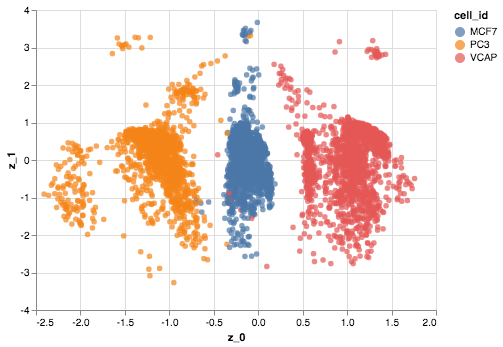

In [10]:
plot_results(encoder=vae.encoder, dataset=vae.test, meta_field="cell_id").interactive()